In [51]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from Helper.K_folds import build_folds, kth_fold
from sklearn.model_selection import GridSearchCV

In [ ]:
#
# Read in data here
#

data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Dropping useless columns
data = data.drop(columns=["id"],inplace=True)
test_data = test_data.drop(columns=["id"], inplace=True) 


In [32]:
# Feature Engineering for Age Bins
age_bins = [0, 39, 49, 59, float("inf")]
age_labels = ["<40", "40-49", "50-59", "60+"]
data["AgeBin"] = pd.cut(data["Age"], bins=age_bins, labels=age_labels, right=True, include_lowest=True)
test_data["AgeBin"] = pd.cut(test_data["Age"], bins=age_bins, labels=age_labels, right=True, include_lowest=True)

In [33]:
# Feature Engineering for exercise angina and chest pain
# Chest pain takes on values in between ()


#data[]


In [34]:
# Exercise Angina x Max HR new feature
# Since exercise angina is binary, we can simply 

# Age-adjusted HR ratio (if not already created)
data["expected_max_hr"] = 220 - data["Age"]
test_data["expected_max_hr"] = 220 - test_data["Age"]

data["hr_ratio"] = data["Max HR"] / data["expected_max_hr"]
test_data["hr_ratio"] = test_data["Max HR"] / test_data["expected_max_hr"]

# Low HR flags
data["low_hr_ratio"] = (data["hr_ratio"] < 0.85).astype(int)    # intuitively, this threshold can be tweaked
test_data["low_hr_ratio"] = (test_data["hr_ratio"] < 0.85).astype(int)

# Interaction
data["exang_low_hr"] = data["Exercise angina"] & data["low_hr_ratio"]
test_data["exang_low_hr"] = test_data["Exercise angina"] & test_data["low_hr_ratio"]


In [35]:
# Hypertension flag
data["hypertension"] = (data["BP"] >= 130).astype(int) # explore this threshold, visualize from EDA
test_data["hypertension"] = (test_data["BP"] >= 130).astype(int)

data["exang_hypertension"] = data["Exercise angina"] & data["hypertension"]
test_data["exang_hypertension"] = test_data["Exercise angina"] & test_data["hypertension"]


# TRAINING MODEL
List of models trained (update as we go along)


1) Random Forest (Public Score = 0.05490 - very clear overfitting duh)
2) Ridge Regression Model
3) Light GBM? (try)

In [38]:
# Get the k-th fold
train_df, val_df = kth_fold(data.iloc[:400000], target_col="Heart Disease", k=5, fold_index=5)

target_col = "Heart Disease"
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]

# Split columns by type
num_cols = X_train.select_dtypes(include=["number"]).columns
cat_cols = X_train.select_dtypes(exclude=["number"]).columns

# Preprocess: one-hot encode categoricals only
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Model pipeline
model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=42)),
    ]
)

# Train + evaluate
model.fit(X_train, y_train)
preds = model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, preds))
print(classification_report(y_val, preds))

Accuracy: 0.881075
              precision    recall  f1-score   support

     Absence       0.89      0.90      0.89     44138
    Presence       0.87      0.86      0.87     35862

    accuracy                           0.88     80000
   macro avg       0.88      0.88      0.88     80000
weighted avg       0.88      0.88      0.88     80000



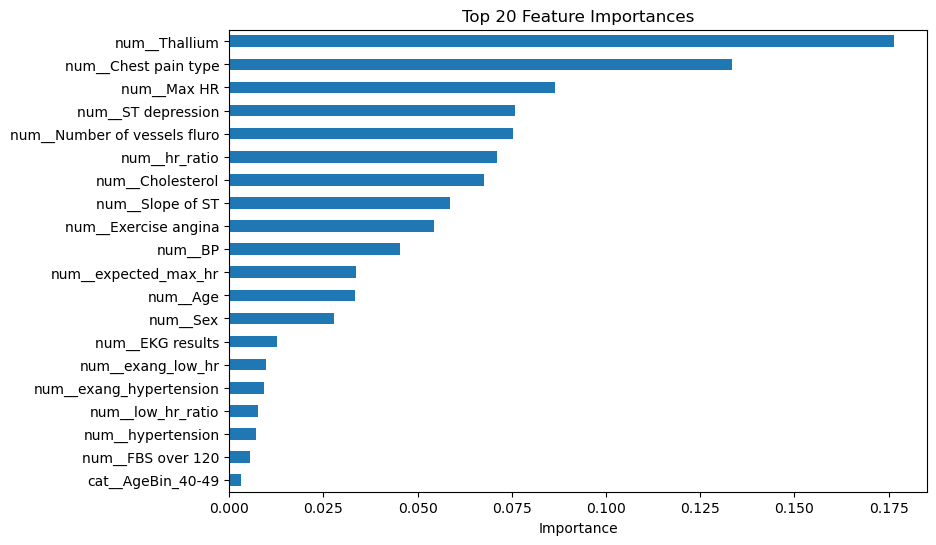

In [39]:

# After model.fit(...)
rf = model.named_steps["clf"]
pre = model.named_steps["preprocess"]

# Feature names after one-hot encoding
feature_names = pre.get_feature_names_out()

# Importance series
feat_imp = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

# Plot top N
top_n = 20
plt.figure(figsize=(9, 6))
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} Feature Importances")
plt.xlabel("Importance")
plt.show()

When we use (x data points) we have an accuracy matrix of ()


1) 20 000 

Accuracy: 0.87725
              precision    recall  f1-score   support

     Absence       0.88      0.90      0.89      2198
    Presence       0.87      0.85      0.86      1802
    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000


2) 200,000
   
Accuracy: 0.882975
              precision    recall  f1-score   support

     Absence       0.89      0.90      0.89     22081
    Presence       0.87      0.86      0.87     17919
    accuracy                           0.88     40000
   macro avg       0.88      0.88      0.88     40000
weighted avg       0.88      0.88      0.88     40000


3) 400,000 (likely some form of overfitting)
   
Accuracy: 0.8826125
              precision    recall  f1-score   support

     Absence       0.89      0.90      0.89     44138
    Presence       0.87      0.86      0.87     35862
    accuracy                           0.88     80000
   macro avg       0.88      0.88      0.88     80000
weighted avg       0.88      0.88      0.88     80000


Top Features found:
1) Thallium
2) Chest pain type
3) Max HR
4) Number of vessels fluro
5) ST depression
6) hr ratio
7) Cholesterol
8) Slope of ST
9) Exercise angina
10) BP
11) expected_max_hr
12) Age

# RIDGE LOGISTIC REGRESSION MODEL

In [55]:

# Get the k-th fold
train_df, val_df = kth_fold(data, target_col="Heart Disease", k=20, fold_index=5)

# Prepare data
target_col = "Heart Disease"
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]

# Split columns by type
num_cols = X_train.select_dtypes(include=["number"]).columns
cat_cols = X_train.select_dtypes(exclude=["number"]).columns

# Preprocess: one-hot encode categoricals only
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Base pipeline
pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(
            penalty="l2",
            solver="lbfgs",
            max_iter=2000,
            n_jobs=-1
        )),
    ]
)

# Grid of C values to search (inverse of lambda)
param_grid = {"clf__C": [0.001, 0.01, 0.1, 1, 10, 100]}

# GridSearch with 5-fold cross-validation using AUC
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

# Fit on training data
grid.fit(X_train, y_train)

# Best regularization
print("Best C (inverse of lambda):", grid.best_params_["clf__C"])
print("Best cross-validated AUC:", grid.best_score_)

# Evaluate on validation set
best_model = grid.best_estimator_
pred_probs = best_model.predict_proba(X_val)[:, 1]  # probability for positive class
val_auc = roc_auc_score(y_val, pred_probs)
print("Validation AUC:", val_auc)


Best C (inverse of lambda): 0.1
Best cross-validated AUC: 0.9505373438024785
Validation AUC: 0.9507118362199082


In [ ]:
# Submission
# Predict on test data
test_preds = best_model.predict_proba(test_data)

# Build submission using sample file for correct columns/order
submission = pd.read_csv("sample_submission.csv")
target_col = "Heart Disease"
submission[target_col] = test_preds

submission.to_csv("submission.csv", index=False)


In [59]:
test_preds

array([[0.03136766, 0.96863234],
       [0.99681654, 0.00318346],
       [0.0056679 , 0.9943321 ],
       ...,
       [0.91770913, 0.08229087],
       [0.75941779, 0.24058221],
       [0.98649003, 0.01350997]])